In [260]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy
import pandas as pd
from load_dataset import load_knapsack

# 量子アニーリング

In [261]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"
solver = "QA"
num_reads = 1000

In [262]:
dataset = load_knapsack("../dataset/knapsack/knap_custom.csv")[4]
W = dataset.capacity
N = dataset.n
cost_list = dataset.cost_list
weight_list = dataset.weight_list
opt = dataset.optimum_state
opt_value = np.dot(dataset.optimum_state, cost_list)
print("W:", W)
print("N:", N)
print("opt:", dataset.optimum_value)
print("   :", opt_value)


W: 104
N: 8
opt: None
   : 900


In [263]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [264]:
print("len x: {}".format(len(x)))
print("len y: {}".format(len(y.array)))

len x: 8
len y: 7


In [231]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c * 2

In [232]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [233]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [189]:
if solver == "QA":
    dw_sampler = DWaveSampler(solver='Advantage_system6.1',
                            token=TOKEN, endpoint=endpoint)
    adj = {}
    for k in Q.keys():
        adj[k] = 1
    embedding = find_embedding(adj, dw_sampler.edgelist)
    # bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
    sampler = FixedEmbeddingComposite(dw_sampler, embedding)
    # sampler = EmbeddingComposite(dw_sampler)
    # sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)
    print("setting DW sampler")
else:
    sampler = SQASampler(num_reads=num_reads)
    print("setting SQA sampler")

setting DW sampler


## フォワードアニーリング

In [190]:
# t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
# s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t = [(0, 100)]
s = [(0, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)


[[(0, 0), (100, 1)]]


In [191]:
def plot_schedules(t, s, save_path="output.jpg", title=None):
    linestyle = ["solid", "dotted", "dashed",
                 "dashdot", (0, (1, 10)), (0, (3, 1, 1, 1))]
    if len(t) == 1:
        fig, ax = plt.subplots(1)
        fig = [fig]
        ax = [ax]
    else:
        fig, ax = plt.subplots(1, len(t))
        fig.set_figwidth(5 * len(t))

    for i in range(len(t)):
        ax[i].plot(t[i], s[i])
        ax[i].set_xlim(-1.0, t[i][-1] + 1.0)
        ax[i].set_ylim(-0.1, 1.1)
        if not title == None:
            ax[i].set_title(title[i].upper())

    plt.tight_layout()
    plt.savefig(save_path)

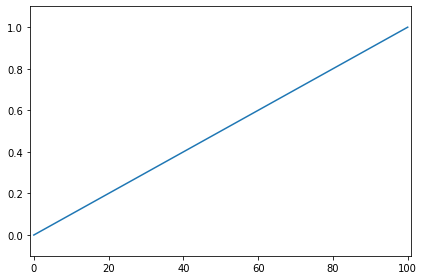

In [192]:
plot_schedules(t, s, "anneal_schedule.jpg")

In [193]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    if solver == "QA":
        samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule))
    else:
        samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")

annealing start
annealing end


In [194]:
def dict_from_sampleview(sampleview):
    d = {}

    for key in sampleview.keys():
        d[key] = sampleview.get(key)
    
    return d

In [195]:
def transform_sample(sampleset, schedule, model):
    # decoded_samples = model.decode_sampleset(
    #     sampleset=sampleset, vartype="BINARY")
    decoded_samples = []
    for sample, record in zip(sampleset, sampleset.record):
        decoded_sample = model.decode_sample(
            dict_from_sampleview(sample), vartype="BINARY")
        decoded_samples.append((decoded_sample, record[1]))

    value_set = []
    for decoded_sample, energy in decoded_samples:
        cost = 0
        weight = 0
        for k in range(N):
            if decoded_sample.array('x', k) != 0:
                cost += cost_list[k]
                weight += weight_list[k]

        sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                          for elem in range(math.ceil(math.log2(W)))])

        value_set.append(
            {"cost": cost, "weight": weight, "energy": energy, "sol_y": sol_y, "broken": decoded_sample.constraints(only_broken=True)})

    value_df = pd.DataFrame(value_set)
    value_df_sorted_cost = value_df[value_df["weight"] <= W].sort_values(by=[
        "cost"])
    value_max = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmax()]
    value_min = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmin()]
    value_ave = value_df_sorted_cost["cost"].mean()
    opt_count = (value_df_sorted_cost["cost"] == opt_value).sum()
    

    # value_df_sorted_by_energy = value_df.sort_values(by=["energy"])

    return {"anneal_time": sampleset.info["timing"]["qpu_anneal_time_per_sample"],
            "anneal_schedule": schedule,
            "info_sets": value_set,
            "best_value": value_max,
            "average_cost": value_ave,
            "worst_value": value_min,
            "dataframe": value_df,
            "opt_count": opt_count,
            "success_rate": opt_count / num_reads}


def v_transform_sample(samplesets, schedules, model):
    if type(samplesets) == list:
        sample_info = []
        for (sampleset, schedule) in zip(samplesets, schedules):
            sample_info.append(transform_sample(sampleset, schedule, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, schedules, model))


In [196]:
def output_sample_info(sample_info):
    print("anneal time = {}".format(sample_info["anneal_time"]))
    print("anneal schedule = {}".format(sample_info["anneal_schedule"]))
    print("---- result -----")
    print("opt_count : " + str(sample_info["opt_count"]))
    print("success rate : " + str(sample_info["success_rate"]))
    print("-----------------")
    print("----- best ------")
    print("slack_Y = {}".format(sample_info["best_value"]["sol_y"]))
    print("broken: {}".format(sample_info["best_value"]["broken"]))
    print("cost : " + str(sample_info["best_value"]["cost"]))
    print("weight : " + str(sample_info["best_value"]["weight"]))
    print("-----------------")
    print("---- average -----")
    print("cost : " + str(sample_info["average_cost"]))
    print("-----------------")
    print("----- worst -----")
    print("slack_Y = {}".format(sample_info["worst_value"]["sol_y"]))
    print("broken: {}".format(sample_info["worst_value"]["broken"]))
    print("cost : " + str(sample_info["worst_value"]["cost"]))
    print("weight : " + str(sample_info["worst_value"]["weight"]))
    print("-----------------")
    print("-----describe----")
    print(sample_info["dataframe"].describe())
    print()


def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)


### 結果

In [197]:
samples_info = v_transform_sample(samplesets, schedules, model)
v_output_sample_info(samples_info)


anneal time = 100.0
anneal schedule = [(0, 0), (100, 1)]
---- result -----
opt_count : 7
success rate : 0.007
-----------------
----- best ------
slack_Y = 2
broken: {'HA': (False, 192.0)}
cost : 51
weight : 26
-----------------
---- average -----
cost : 31.17479674796748
-----------------
----- worst -----
slack_Y = 30
broken: {'HA': (False, 48.0)}
cost : 0
weight : 0
-----------------
-----describe----
             cost      weight        energy       sol_y
count  290.000000  290.000000    290.000000  290.000000
mean    34.989655   18.141379 -31523.817241   10.848276
std     13.782162    6.999062   1352.091413    7.938196
min      0.000000    0.000000 -32499.000000    0.000000
25%     28.000000   15.000000 -32295.000000    4.000000
50%     37.000000   19.000000 -32022.500000    9.000000
75%     44.000000   23.000000 -31280.250000   17.000000
max     76.000000   39.000000 -23103.000000   30.000000



In [198]:
len(samples_info[0]["dataframe"])


290

## リバースアニーリング

### 最良値採用

In [199]:
init = samplesets[0].samples()[int(len(samplesets[0].samples()) / 2)]

In [200]:
tau = 100

t = []
s = []

s_inv = 0.2
t_inv = tau * (1 - s_inv)

t.append((0,  t_inv, tau))
s.append((1, s_inv, 1.0))

s_inv = 0.4
t_inv = tau * (1 - s_inv)

t.append((0,  t_inv, tau))
s.append((1, s_inv, 1.0))

s_inv = 0.6
t_inv = tau * (1 - s_inv)

t.append((0,  t_inv, tau))
s.append((1, s_inv, 1.0))

reverse_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_schedules)


[[(0, 1), (80.0, 0.2), (100, 1.0)], [(0, 1), (60.0, 0.4), (100, 1.0)], [(0, 1), (40.0, 0.6), (100, 1.0)]]


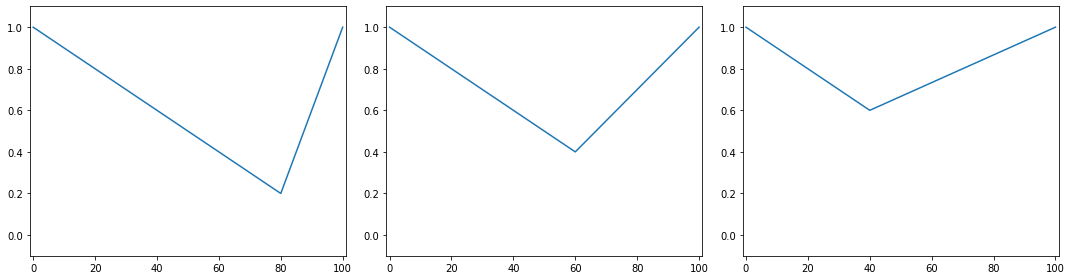

In [201]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [202]:
reverse_samplesets = []
for schedule in reverse_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=True))
    else:
        reverse_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end
annealing start
annealing end
annealing start
annealing end


#### 結果

In [203]:
reverse_samples_info = v_transform_sample(reverse_samplesets, reverse_schedules, model)
v_output_sample_info(reverse_samples_info)


anneal time = 100.0
anneal schedule = [(0, 1), (80.0, 0.2), (100, 1.0)]
---- result -----
opt_count : 15
success rate : 0.015
-----------------
----- best ------
slack_Y = 1
broken: {'HA': (False, 48.0)}
cost : 51
weight : 26
-----------------
---- average -----
cost : 29.761692650334076
-----------------
----- worst -----
slack_Y = 28
broken: {'HA': (False, 432.0)}
cost : 0
weight : 0
-----------------
-----describe----
              cost       weight        energy        sol_y
count  1000.000000  1000.000000   1000.000000  1000.000000
mean     32.258000    16.743000 -31759.730000    12.413000
std      12.815993     6.502864   1318.470901     8.078347
min       0.000000     0.000000 -32499.000000     0.000000
25%      24.000000    12.000000 -32424.000000     6.000000
50%      31.000000    17.000000 -32063.000000    12.000000
75%      40.000000    21.000000 -31695.000000    19.000000
max      63.000000    32.000000 -15172.000000    31.000000

anneal time = 100.0
anneal schedule = [(0, 

### 最悪値採用

In [204]:
init = samplesets[0].samples()[-1]

In [205]:
reverse_worst_schedules = deepcopy(reverse_schedules)
reverse_worst_schedules = []
print(reverse_worst_schedules)

[]


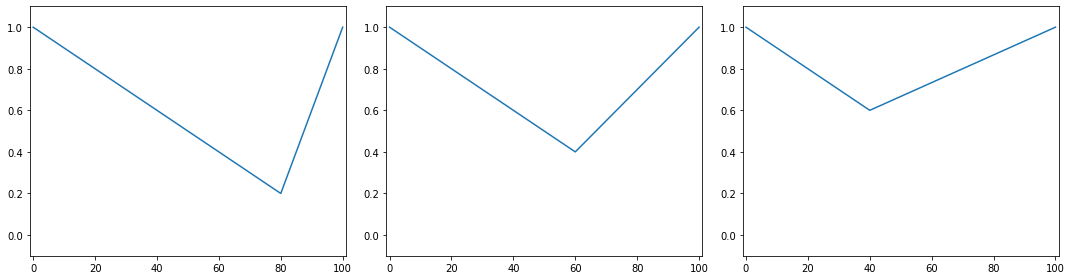

In [206]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")

In [207]:
reverse_worst_samplesets = []
for schedule in reverse_worst_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_worst_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init, reinitialize_state=True))
    else:
        reverse_worst_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


#### 結果

In [208]:
reverse_worst_samples_info = v_transform_sample(
    reverse_worst_samplesets, reverse_worst_schedules, model)
v_output_sample_info(reverse_worst_samplesets)


In [209]:
for info in samples_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], info["success_rate"], "\\\\")
for info in reverse_samples_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], info["success_rate"], "\\\\")
for info in reverse_worst_samples_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], info["success_rate"], "\\\\")
for info in reverse_worst_samples_info:
    print(info["best_value"]["cost"], "&",
          info["average_cost"], "&", info["worst_value"]["cost"], info["success_rate"], "\\\\")


51 & 31.17479674796748 & 0 0.007 \\
51 & 29.761692650334076 & 0 0.015 \\
51 & 31.078860898138007 & 0 0.017 \\
51 & 23.295591182364728 & 0 0.046 \\


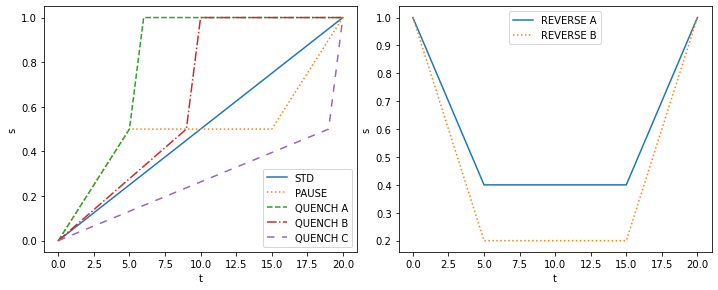

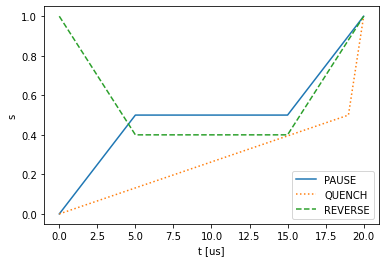

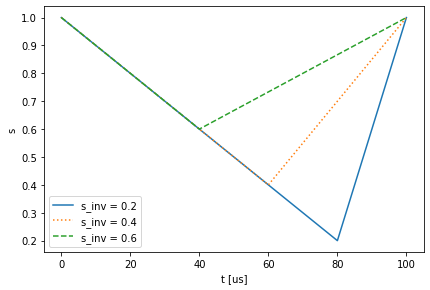

In [289]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
t2 = [(0, 5, 15, 20), (0, 5, 15, 20)]
s2 = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
t_set = [t, t2]
s_set = [s, s2]
label = [["STD", "PAUSE", "QUENCH A", "QUENCH B",
          "QUENCH C"], ["REVERSE A", "REVERSE B"]]
linestyle = ["solid", "dotted", "dashed",
             "dashdot",  (0, (5, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.tight_layout()

for i in range(2):
    for j in range(len(t_set[i])):
        ax[i].plot(t_set[i][j], s_set[i][j], label=label[i]
                   [j], linestyle=linestyle[j])

        ax[i].set_xlabel("t")
        ax[i].set_ylabel("s")
        ax[i].legend(loc=0)
plt.savefig("fixed-anneal_schedule.jpg")


t = [ (0, 5, 15, 20), (0, 19, 20), (0, 5, 15, 20)]
s = [ (0, 0.5, 0.5, 1),  (0, 0.5, 1), (1.0, 0.4, 0.4, 1.0)]
label = ["PAUSE", "QUENCH", "REVERSE"]
fig, ax = plt.subplots()

for i in range(len(t)):
    ax.plot(t[i], s[i], label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t [us]")
    ax.set_ylabel("s")
    ax.legend(loc=0)

plt.savefig("fixed-example_schedules.jpg")

fig, ax = plt.subplots()
label = ["s_inv = 0.2", "s_inv = 0.4", "s_inv = 0.6"]
fig.set_figwidth(6)
fig.tight_layout()
for i, schedule in enumerate(reverse_schedules):
    t = []
    s = []
    for tmp_t, tmp_s in schedule:
        t.append(tmp_t)
        s.append(tmp_s)
        
    ax.plot(t, s, label=label[i], linestyle=linestyle[i])
    ax.set_xlabel("t [us]")
    ax.set_ylabel("s")
    ax.legend(loc=0)
    
plt.savefig("reverse_schedules.jpg")

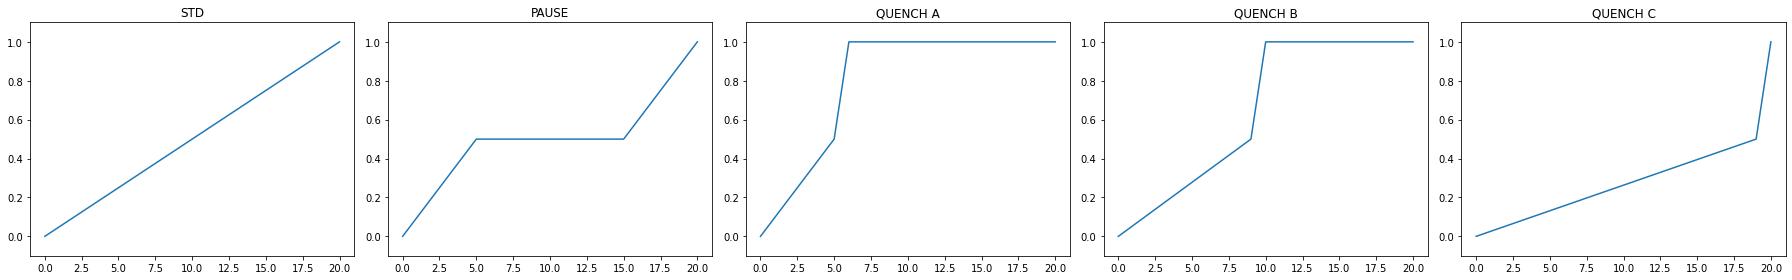

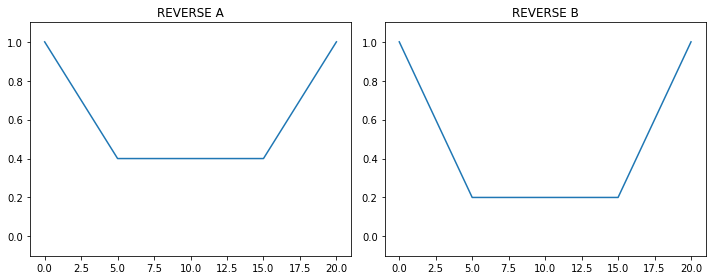

In [211]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
plot_schedules(t, s, "pause_quench_schedule.jpg", [
               "std", "pause", "quench A", "quench B", "quench C"])

t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
plot_schedules(t, s, "reverse_anneal.jpg", [
               "reverse A", "reverse B"]) 


TypeError: 'AxesSubplot' object is not subscriptable

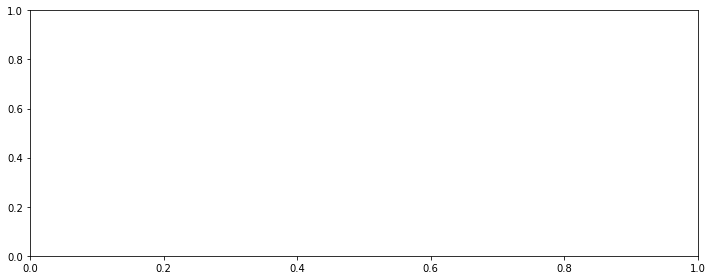

In [212]:
s = [(0, 1), (0,1)]
y = [(0, 1), (1,0)]

label = ["A(s)","B(s)"]
linestyle = ["solid", "dotted", "dashed",
             "dashdot",  (0, (5, 5)), (0, (3, 1, 1, 1))]

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.tight_layout()

for i in range(2):
    for j in range(len(t_set[i])):
        ax[i].plot(t_set[i][j], s_set[i][j], label=label[i]
                   [j], linestyle=linestyle[j])

        ax[i].set_xlabel("t")
        ax[i].set_ylabel("s")
        ax[i].legend(loc=0)
plt.savefig("fn-A-B")


